In [28]:
# ==============================================================================
#           ANÁLISE DE PADRÕES DE ANOMALIA EM TRANSAÇÕES PIX
# ==============================================================================
# Este script foi projetado para ler um arquivo de transações, aprender os
# perfis de transações anômalas e, em seguida, gerar um novo arquivo CSV
# contendo apenas as transações suspeitas, com uma explicação do motivo.
# ==============================================================================

# Importação das bibliotecas necessárias
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- FASE 1: Carregamento e Exploração dos Dados ---
print("\n" + "="*60)
print("--- FASE 1: Carregamento e Exploração dos Dados ---")
print("="*60)
print("\n[OBJETIVO] O primeiro passo é carregar nosso arquivo CSV para a memória e fazer uma rápida inspeção para entender sua estrutura.")

df = pd.read_csv('comprovantes_pix_10000_anomalias.csv', sep=';')

print("\n[AÇÃO] Removendo colunas desnecessárias para a análise de padrões...")

# Lista das colunas que identificamos como não relevantes para encontrar padrões gerais
colunas_para_remover = [
    'EndToEndId', 
    'Moeda', 
    'Pagador_Nome', 
    'Pagador_CPF_CNPJ',
    'Recebedor_Nome', 
    'Recebedor_CPF_CNPJ', 
    'ChavePix_Utilizada',
    'Descricao'
]

# O comando .drop() remove as colunas da lista
df = df.drop(columns=colunas_para_remover)

print(f"[SUCESSO] Colunas removidas. O DataFrame agora tem {df.shape[1]} colunas.")
print("[INFO] Verificando a estrutura do DataFrame após a limpeza:")
df.info()


--- FASE 1: Carregamento e Exploração dos Dados ---

[OBJETIVO] O primeiro passo é carregar nosso arquivo CSV para a memória e fazer uma rápida inspeção para entender sua estrutura.

[AÇÃO] Removendo colunas desnecessárias para a análise de padrões...
[SUCESSO] Colunas removidas. O DataFrame agora tem 7 colunas.
[INFO] Verificando a estrutura do DataFrame após a limpeza:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DataHora         10000 non-null  object 
 1   Valor            10000 non-null  float64
 2   Pagador_Banco    10000 non-null  object 
 3   Recebedor_Banco  10000 non-null  object 
 4   TipoChave        10000 non-null  object 
 5   Status           10000 non-null  object 
 6   Anomalia         10000 non-null  int64  
dtypes: float64(1), int64(1), object(5)
memory usage: 547.0+ KB


In [29]:

# --- FASE 2: Preparação dos Dados e Criação de Novas Features ---
print("\n" + "="*60)
print("--- FASE 2: Preparação dos Dados e Criação de Novas Features ---")
print("="*60)
print("\n[OBJETIVO] Dados brutos raramente estão prontos para análise. Vamos limpá-los e criar novas colunas (features) que ajudem o algoritmo a encontrar padrões.")

# Conversão da coluna de data e hora
print("\n[AÇÃO] Convertendo a coluna 'DataHora' para um formato de data que o Python entende...")
df['DataHora'] = pd.to_datetime(df['DataHora'], errors='coerce')
df.dropna(subset=['DataHora'], inplace=True)
print("[SUCESSO] 'DataHora' agora é uma coluna de data, permitindo extrair informações como hora, dia, etc.")

# Criação da coluna 'periodo_dia'
print("\n[AÇÃO] Criando uma nova coluna chamada 'periodo_dia' a partir da hora da transação...")
def get_periodo_dia(hour):
    if 0 <= hour < 6: return 'Madrugada'
    elif 6 <= hour < 12: return 'Manha'
    elif 12 <= hour < 18: return 'Tarde'
    else: return 'Noite'
df['periodo_dia'] = df['DataHora'].dt.hour.apply(get_periodo_dia)
print("[SUCESSO] Coluna 'periodo_dia' criada. Isso transforma a hora (numérica) em uma categoria (texto), o que é ótimo para encontrar regras.")
print("[ANÁLISE] Vamos ver a distribuição de transações por período:")
print(df['periodo_dia'].value_counts())

# Criação da coluna 'valor_cat'
print("\n[AÇÃO] Criando a coluna 'valor_cat' para agrupar os valores das transações em faixas (Baixo, Medio, Alto)...")
df['valor_cat'] = pd.qcut(df['Valor'], q=3, labels=['Baixo', 'Medio', 'Alto'])
print("[SUCESSO] Coluna 'valor_cat' criada. Agrupar valores ajuda o algoritmo a encontrar padrões como 'transações de baixo valor são suspeitas'.")
print("[ANÁLISE] Distribuição de transações por categoria de valor:")
print(df['valor_cat'].value_counts())



--- FASE 2: Preparação dos Dados e Criação de Novas Features ---

[OBJETIVO] Dados brutos raramente estão prontos para análise. Vamos limpá-los e criar novas colunas (features) que ajudem o algoritmo a encontrar padrões.

[AÇÃO] Convertendo a coluna 'DataHora' para um formato de data que o Python entende...
[SUCESSO] 'DataHora' agora é uma coluna de data, permitindo extrair informações como hora, dia, etc.

[AÇÃO] Criando uma nova coluna chamada 'periodo_dia' a partir da hora da transação...
[SUCESSO] Coluna 'periodo_dia' criada. Isso transforma a hora (numérica) em uma categoria (texto), o que é ótimo para encontrar regras.
[ANÁLISE] Vamos ver a distribuição de transações por período:
periodo_dia
Noite        2554
Madrugada    2501
Manha        2463
Tarde        2458
Name: count, dtype: int64

[AÇÃO] Criando a coluna 'valor_cat' para agrupar os valores das transações em faixas (Baixo, Medio, Alto)...
[SUCESSO] Coluna 'valor_cat' criada. Agrupar valores ajuda o algoritmo a encontrar p

In [30]:
# --- FASE 3: Transformando os Dados para o Formato de 'Cesta de Compras' ---
print("\n" + "="*60)
print("--- FASE 3: Transformando para o Formato de 'Cesta de Compras' ---")
print("="*60)
print("\n[OBJETIVO] O algoritmo que usaremos (Apriori) foi criado para analisar cestas de compras. Precisamos formatar nossos dados para que cada transação pareça uma 'cesta' e suas características (banco, status, etc.) pareçam 'itens' dentro dela.")

df_transacional = df[['Pagador_Banco', 'Recebedor_Banco', 'TipoChave', 'Status', 'periodo_dia', 'valor_cat', 'Anomalia']]

records = []
for i in range(len(df_transacional)):
    records.append([str(col) + "=" + str(val) for col, val in df_transacional.iloc[i].items()])

print(f"\n[SUCESSO] Dados convertidos para o formato de lista.")
print("[EXEMPLO] Uma transação que era uma linha na tabela, agora se parece com isto:")
print(records[0])



--- FASE 3: Transformando para o Formato de 'Cesta de Compras' ---

[OBJETIVO] O algoritmo que usaremos (Apriori) foi criado para analisar cestas de compras. Precisamos formatar nossos dados para que cada transação pareça uma 'cesta' e suas características (banco, status, etc.) pareçam 'itens' dentro dela.

[SUCESSO] Dados convertidos para o formato de lista.
[EXEMPLO] Uma transação que era uma linha na tabela, agora se parece com isto:
['Pagador_Banco=BTG Pactual', 'Recebedor_Banco=Nubank', 'TipoChave=Telefone', 'Status=Concluída', 'periodo_dia=Noite', 'valor_cat=Alto', 'Anomalia=0']


In [31]:
# --- FASE 4: Encontrando Padrões Frequentes (Mineração) ---
print("\n" + "="*60)
print("--- FASE 4: Encontrando Padrões Frequentes (Mineração) ---")
print("="*60)
print("\n[OBJETIVO] Agora começa a 'mineração'. Vamos usar o algoritmo Apriori para ler todas as 'cestas' e encontrar combinações de 'itens' que aparecem com frequência.")

te = TransactionEncoder()
te_ary = te.fit(records).transform(records)
df_onehot = pd.DataFrame(te_ary, columns=te.columns_)

min_sup = 0.002
frequent_itemsets = apriori(df_onehot, min_support=min_sup, use_colnames=True)
print(f"\n[SUCESSO] O algoritmo Apriori analisou os dados com um suporte mínimo de {min_sup*100}%.")
print("O que isso significa? Ele buscou combinações de características que aparecem em pelo menos 0.2% de todas as transações.")
print(f"\n[RESULTADO] Foram encontrados {len(frequent_itemsets)} 'itemsets' (combinações) frequentes.")
print("[AMOSTRA] Abaixo estão os 10 itemsets mais comuns encontrados:")
print(frequent_itemsets.sort_values(by='support', ascending=False).head(10))


--- FASE 4: Encontrando Padrões Frequentes (Mineração) ---

[OBJETIVO] Agora começa a 'mineração'. Vamos usar o algoritmo Apriori para ler todas as 'cestas' e encontrar combinações de 'itens' que aparecem com frequência.

[SUCESSO] O algoritmo Apriori analisou os dados com um suporte mínimo de 0.2%.
O que isso significa? Ele buscou combinações de características que aparecem em pelo menos 0.2% de todas as transações.

[RESULTADO] Foram encontrados 10252 'itemsets' (combinações) frequentes.
[AMOSTRA] Abaixo estão os 10 itemsets mais comuns encontrados:
     support                        itemsets
0   0.992382                    (Anomalia=0)
28  0.336006              (Status=Estornada)
27  0.334002              (Status=Concluída)
67  0.333601  (Status=Estornada, Anomalia=0)
39  0.333400                (valor_cat=Alto)
41  0.333300               (valor_cat=Medio)
40  0.333300               (valor_cat=Baixo)
80  0.331596   (Anomalia=0, valor_cat=Medio)
78  0.331295    (Anomalia=0, valor_c

In [32]:

# --- FASE 5: Gerando as Regras de Associação ---
print("\n" + "="*60)
print("--- FASE 5: Gerando as Regras de Associação ---")
print("="*60)
print("\n[OBJETIVO] Com os 'itemsets' frequentes em mãos, podemos agora gerar as 'regras de associação', que são as pérolas da nossa análise. Elas têm o formato 'SE acontecer X, ENTÃO provavelmente acontecerá Y'.")

rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.05)
rules['consequents'] = rules['consequents'].apply(lambda x: list(x)[0]).astype("unicode")
rules_anomalia = rules[rules['consequents'] == 'Anomalia=1']
rules_anomalia_sorted = rules_anomalia.sort_values(by='lift', ascending=False)

print("\n[SUCESSO] Regras geradas e filtradas para mostrar apenas aquelas que levam a uma anomalia.")
print(f"[RESULTADO] Encontramos {len(rules_anomalia_sorted)} perfis de transações que são fortes indicadores de anomalia.")
print("\n[INTERPRETAÇÃO] Como ler a tabela de regras abaixo:")
print(" - 'antecedents' (SE...): As condições da transação.")
print(" - 'consequents' (ENTÃO...): O resultado, que no nosso caso é sempre 'Anomalia=1'.")
print(" - 'confidence': A 'taxa de acerto' da regra. Um valor de 1.0 significa 100% de certeza.")
print(" - 'lift': A 'força' da regra. Um lift de 12 significa que a regra é 12x mais provável de indicar uma anomalia do que o acaso. É a métrica mais importante!")
print("\n[AMOSTRA] As 5 regras mais fortes encontradas:")
print(rules_anomalia_sorted.head())


--- FASE 5: Gerando as Regras de Associação ---

[OBJETIVO] Com os 'itemsets' frequentes em mãos, podemos agora gerar as 'regras de associação', que são as pérolas da nossa análise. Elas têm o formato 'SE acontecer X, ENTÃO provavelmente acontecerá Y'.

[SUCESSO] Regras geradas e filtradas para mostrar apenas aquelas que levam a uma anomalia.
[RESULTADO] Encontramos 1 perfis de transações que são fortes indicadores de anomalia.

[INTERPRETAÇÃO] Como ler a tabela de regras abaixo:
 - 'antecedents' (SE...): As condições da transação.
 - 'consequents' (ENTÃO...): O resultado, que no nosso caso é sempre 'Anomalia=1'.
 - 'confidence': A 'taxa de acerto' da regra. Um valor de 1.0 significa 100% de certeza.
 - 'lift': A 'força' da regra. Um lift de 12 significa que a regra é 12x mais provável de indicar uma anomalia do que o acaso. É a métrica mais importante!

[AMOSTRA] As 5 regras mais fortes encontradas:
                              antecedents consequents  antecedent support  \
79  (Rec

In [33]:





# --- FASE 6: Caça às Anomalias e Geração do CSV Final ---
print("\n" + "="*60)
print("--- FASE 6: Caça às Anomalias e Geração do CSV Final ---")
print("="*60)
print("\n[OBJETIVO] Agora, a parte mais prática! Vamos usar as regras que aprendemos para 'caçar' as transações suspeitas no nosso arquivo original e criar um relatório final em CSV.")
print("\n[PROCESSO] O código irá varrer o arquivo de transações e, para cada uma, verificar se ela corresponde a algum dos perfis de anomalia encontrados...")

df['motivo_sinalizacao'] = None

for index, rule in rules_anomalia_sorted.iterrows():
    conditions = list(rule['antecedents'])
    filtro_pandas = None
    for i, condition in enumerate(conditions):
        coluna, valor = condition.split('=', 1)
        if df[coluna].dtype == 'int64': valor = int(valor)
        elif df[coluna].dtype == 'float64': valor = float(valor)
        if i == 0:
            filtro_pandas = (df[coluna] == valor)
        else:
            filtro_pandas = filtro_pandas & (df[coluna] == valor)
    motivo = f"Regra (Força: {rule['lift']:.2f}): {' E '.join(conditions)}"
    df.loc[filtro_pandas & df['motivo_sinalizacao'].isnull(), 'motivo_sinalizacao'] = motivo

df_anomalias_sugeridas = df.dropna(subset=['motivo_sinalizacao'])
print(f"\n[ANÁLISE CONCLUÍDA] {len(df_anomalias_sugeridas)} transações foram sinalizadas como potencialmente anômalas.")

output_filename = 'transacoes_sinalizadas_como_anomalias.csv'
df_anomalias_sugeridas.to_csv(output_filename, sep=';', index=False, encoding='utf-8-sig')

print("\n" + "="*60)
print("--- RESULTADO FINAL ---")
print("="*60)
print(f"\n[SUCESSO TOTAL!] Um novo arquivo chamado '{output_filename}' foi criado na mesma pasta deste script.")
print("Este arquivo contém APENAS as transações suspeitas e uma nova coluna 'motivo_sinalizacao' que explica por que cada uma foi marcada.")
print("\n[AMOSTRA DO ARQUIVO FINAL] Veja como ficou a saída:")
print(df_anomalias_sugeridas[['DataHora', 'Valor', 'Pagador_Banco', 'Status', 'Anomalia', 'motivo_sinalizacao']].head(10))


--- FASE 6: Caça às Anomalias e Geração do CSV Final ---

[OBJETIVO] Agora, a parte mais prática! Vamos usar as regras que aprendemos para 'caçar' as transações suspeitas no nosso arquivo original e criar um relatório final em CSV.

[PROCESSO] O código irá varrer o arquivo de transações e, para cada uma, verificar se ela corresponde a algum dos perfis de anomalia encontrados...

[ANÁLISE CONCLUÍDA] 20 transações foram sinalizadas como potencialmente anômalas.

--- RESULTADO FINAL ---

[SUCESSO TOTAL!] Um novo arquivo chamado 'transacoes_sinalizadas_como_anomalias.csv' foi criado na mesma pasta deste script.
Este arquivo contém APENAS as transações suspeitas e uma nova coluna 'motivo_sinalizacao' que explica por que cada uma foi marcada.

[AMOSTRA DO ARQUIVO FINAL] Veja como ficou a saída:
                DataHora    Valor    Pagador_Banco     Status  Anomalia  \
701  2025-07-09 11:41:56  4288.36      Banco Inter   Pendente         1   
1101 2025-08-19 10:36:56  4874.61  Banco do Brasi

In [34]:
# ==============================================================================
# FASE FINAL: ANÁLISE PERCENTUAL E VISUALIZAÇÃO DETALHADA DAS ANOMALIAS
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("\n" + "="*60)
print("--- FASE FINAL: Análise Focada no Perfil das Anomalias ---")
print("="*60)

# Verificação para garantir que anomalias foram encontradas antes de prosseguir
if 'df_anomalias_sugeridas' in locals() and not df_anomalias_sugeridas.empty:
    print(f"\n[OBJETIVO] Analisar em detalhe o perfil das {len(df_anomalias_sugeridas)} transações sinalizadas como anomalias.")
    sns.set_theme(style="whitegrid")
else:
    print("Nenhuma anomalia foi sinalizada para análise. Execute as fases anteriores primeiro.")


--- FASE FINAL: Análise Focada no Perfil das Anomalias ---

[OBJETIVO] Analisar em detalhe o perfil das 20 transações sinalizadas como anomalias.



[AÇÃO] Gerando Gráfico 1: Distribuição por Banco Pagador...


/tmp/ipykernel_40077/4240868664.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pagador_banco_full_percent.values, y=pagador_banco_full_percent.index, palette='viridis', orient='h')


[SUCESSO] Gráfico 'grafico_todos_bancos_anomalias.png' salvo.


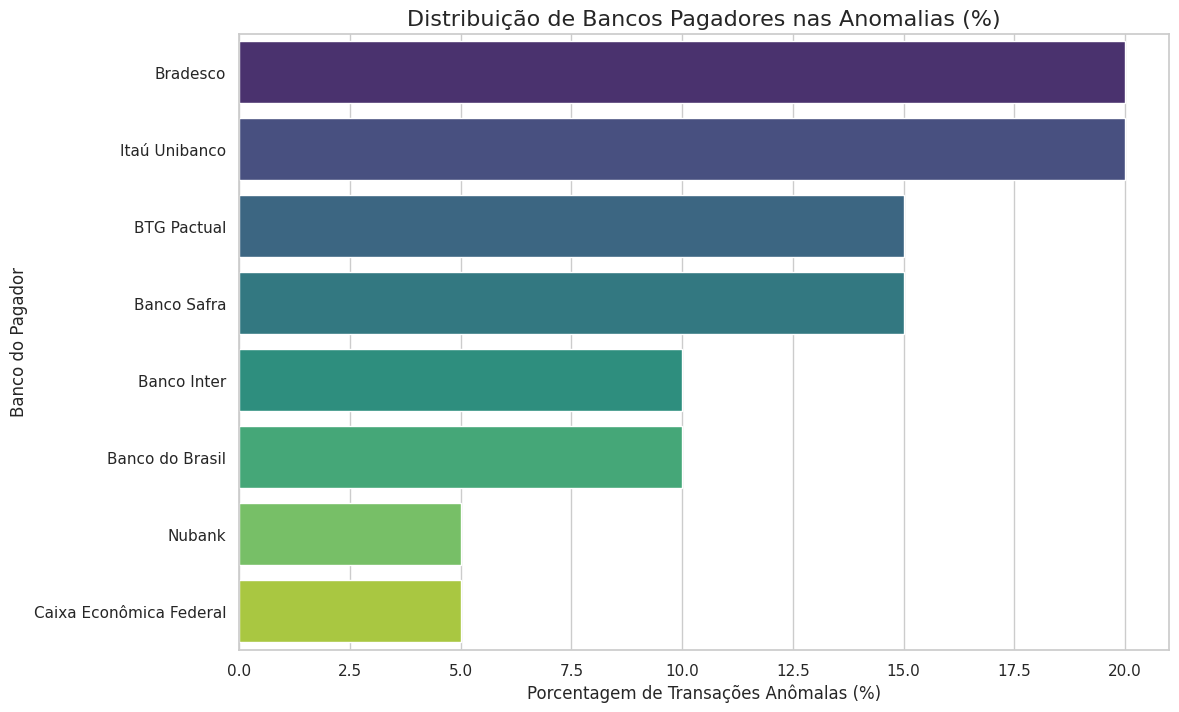

In [35]:
# --- GRÁFICO 1: Distribuição por Banco do Pagador ---
if 'df_anomalias_sugeridas' in locals() and not df_anomalias_sugeridas.empty:
    print("\n[AÇÃO] Gerando Gráfico 1: Distribuição por Banco Pagador...")
    pagador_banco_full_percent = df_anomalias_sugeridas['Pagador_Banco'].value_counts(normalize=True) * 100
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x=pagador_banco_full_percent.values, y=pagador_banco_full_percent.index, palette='viridis', orient='h')
    plt.title('Distribuição de Bancos Pagadores nas Anomalias (%)', fontsize=16)
    plt.xlabel('Porcentagem de Transações Anômalas (%)', fontsize=12)
    plt.ylabel('Banco do Pagador', fontsize=12)
    plt.savefig('grafico_todos_bancos_anomalias.png', bbox_inches='tight')
    print("[SUCESSO] Gráfico 'grafico_todos_bancos_anomalias.png' salvo.")


[AÇÃO] Gerando Gráfico 2: Distribuição por Tipo de Chave PIX...
[SUCESSO] Gráfico 'grafico_tipochave_anomalias.png' salvo.


/tmp/ipykernel_40077/4034718155.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tipo_chave_percent.index, y=tipo_chave_percent.values, palette='plasma')


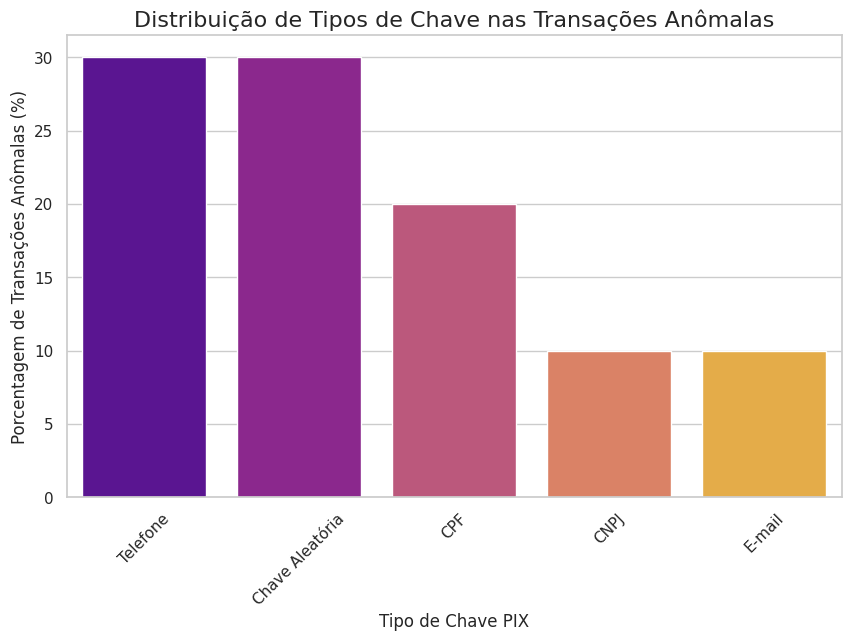

In [36]:
# --- GRÁFICO 2: Distribuição por Tipo de Chave PIX ---
if 'df_anomalias_sugeridas' in locals() and not df_anomalias_sugeridas.empty:
    print("\n[AÇÃO] Gerando Gráfico 2: Distribuição por Tipo de Chave PIX...")
    tipo_chave_percent = df_anomalias_sugeridas['TipoChave'].value_counts(normalize=True) * 100
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=tipo_chave_percent.index, y=tipo_chave_percent.values, palette='plasma')
    plt.title('Distribuição de Tipos de Chave nas Transações Anômalas', fontsize=16)
    plt.xlabel('Tipo de Chave PIX', fontsize=12)
    plt.ylabel('Porcentagem de Transações Anômalas (%)', fontsize=12)
    plt.xticks(rotation=45)
    plt.savefig('grafico_tipochave_anomalias.png', bbox_inches='tight')
    print("[SUCESSO] Gráfico 'grafico_tipochave_anomalias.png' salvo.")


[AÇÃO] Gerando Gráfico 3: Distribuição por Status da Transação...
[SUCESSO] Gráfico 'grafico_status_anomalias.png' salvo.


/tmp/ipykernel_40077/1004065784.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=status_percent.index, y=status_percent.values, palette='magma')


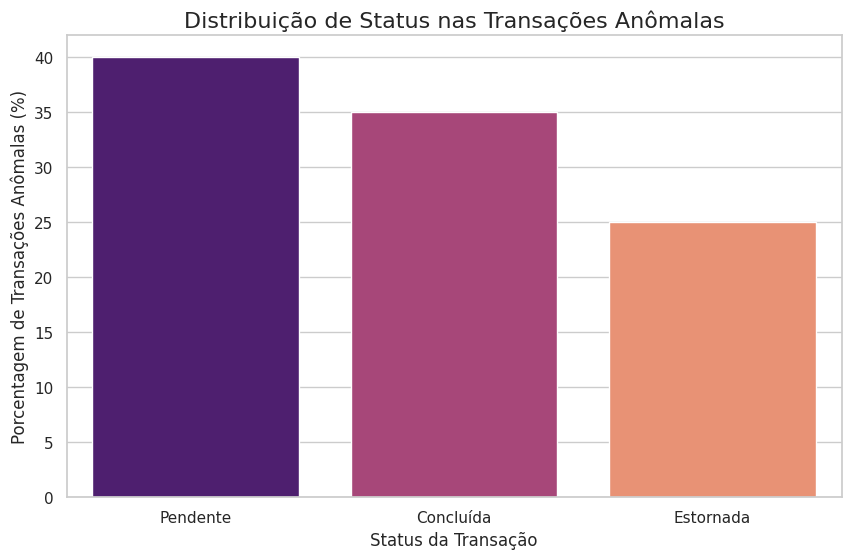

In [37]:
# --- GRÁFICO 3: Distribuição por Status da Transação ---
if 'df_anomalias_sugeridas' in locals() and not df_anomalias_sugeridas.empty:
    print("\n[AÇÃO] Gerando Gráfico 3: Distribuição por Status da Transação...")
    status_percent = df_anomalias_sugeridas['Status'].value_counts(normalize=True) * 100
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=status_percent.index, y=status_percent.values, palette='magma')
    plt.title('Distribuição de Status nas Transações Anômalas', fontsize=16)
    plt.xlabel('Status da Transação', fontsize=12)
    plt.ylabel('Porcentagem de Transações Anômalas (%)', fontsize=12)
    plt.savefig('grafico_status_anomalias.png', bbox_inches='tight')
    print("[SUCESSO] Gráfico 'grafico_status_anomalias.png' salvo.")


[AÇÃO] Gerando Gráfico 4: Histograma dos Valores das Fraudes...
[SUCESSO] Gráfico 'grafico_histograma_valores_anomalias.png' salvo.


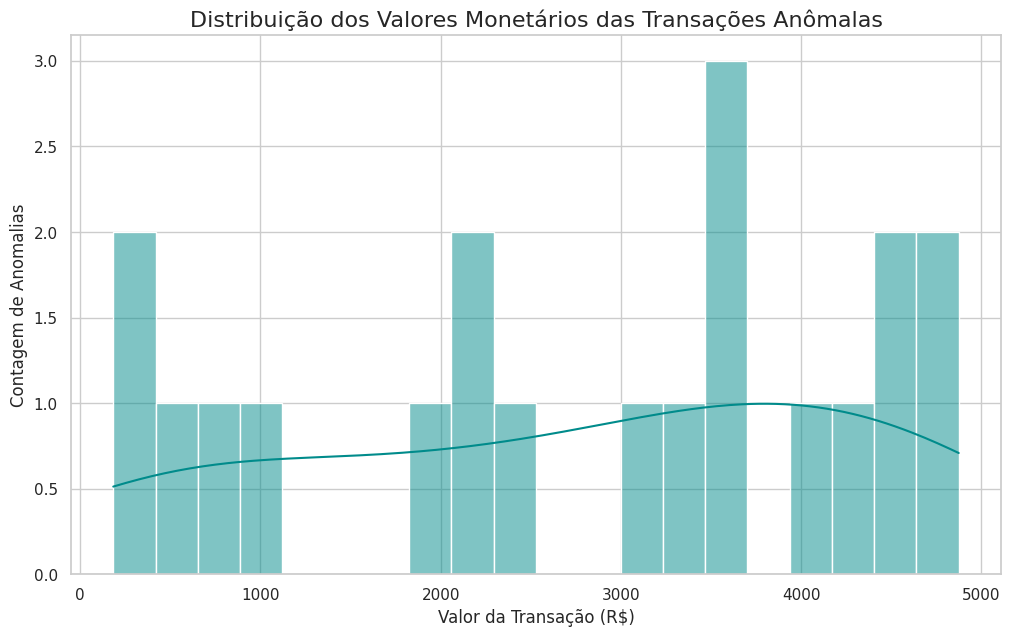

In [38]:
# --- GRÁFICO 4: Histograma dos Valores das Fraudes ---
if 'df_anomalias_sugeridas' in locals() and not df_anomalias_sugeridas.empty:
    print("\n[AÇÃO] Gerando Gráfico 4: Histograma dos Valores das Fraudes...")
    plt.figure(figsize=(12, 7))
    sns.histplot(data=df_anomalias_sugeridas, x='Valor', kde=True, bins=20, color='darkcyan')
    plt.title('Distribuição dos Valores Monetários das Transações Anômalas', fontsize=16)
    plt.xlabel('Valor da Transação (R$)', fontsize=12)
    plt.ylabel('Contagem de Anomalias', fontsize=12)
    plt.savefig('grafico_histograma_valores_anomalias.png', bbox_inches='tight')
    print("[SUCESSO] Gráfico 'grafico_histograma_valores_anomalias.png' salvo.")


[AÇÃO] Gerando Gráfico 5: Contagem de Fraudes por Hora do Dia...


/tmp/ipykernel_40077/2431385518.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_anomalias_sugeridas['hora'] = pd.to_datetime(df_anomalias_sugeridas['DataHora']).dt.hour
/tmp/ipykernel_40077/2431385518.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_anomalias_sugeridas, x='hora', palette='rocket', order=range(24))


[SUCESSO] Gráfico 'grafico_contagem_por_hora_anomalias.png' salvo.


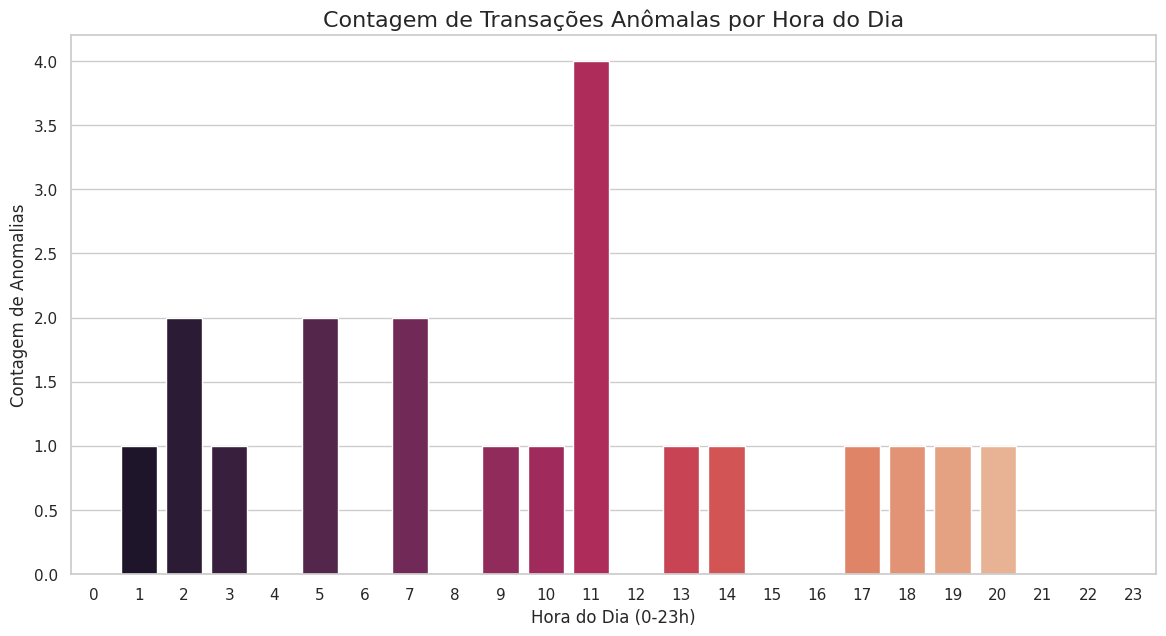

In [39]:
# --- GRÁFICO 5: Contagem de Fraudes por Hora do Dia ---
if 'df_anomalias_sugeridas' in locals() and not df_anomalias_sugeridas.empty:
    print("\n[AÇÃO] Gerando Gráfico 5: Contagem de Fraudes por Hora do Dia...")
    df_anomalias_sugeridas['hora'] = pd.to_datetime(df_anomalias_sugeridas['DataHora']).dt.hour
    
    plt.figure(figsize=(14, 7))
    sns.countplot(data=df_anomalias_sugeridas, x='hora', palette='rocket', order=range(24))
    plt.title('Contagem de Transações Anômalas por Hora do Dia', fontsize=16)
    plt.xlabel('Hora do Dia (0-23h)', fontsize=12)
    plt.ylabel('Contagem de Anomalias', fontsize=12)
    plt.savefig('grafico_contagem_por_hora_anomalias.png', bbox_inches='tight')
    print("[SUCESSO] Gráfico 'grafico_contagem_por_hora_anomalias.png' salvo.")


[AÇÃO] Gerando Gráfico 6: Heatmap Banco Pagador vs. Tipo de Chave...
[SUCESSO] Gráfico 'grafico_heatmap_banco_chave.png' salvo.


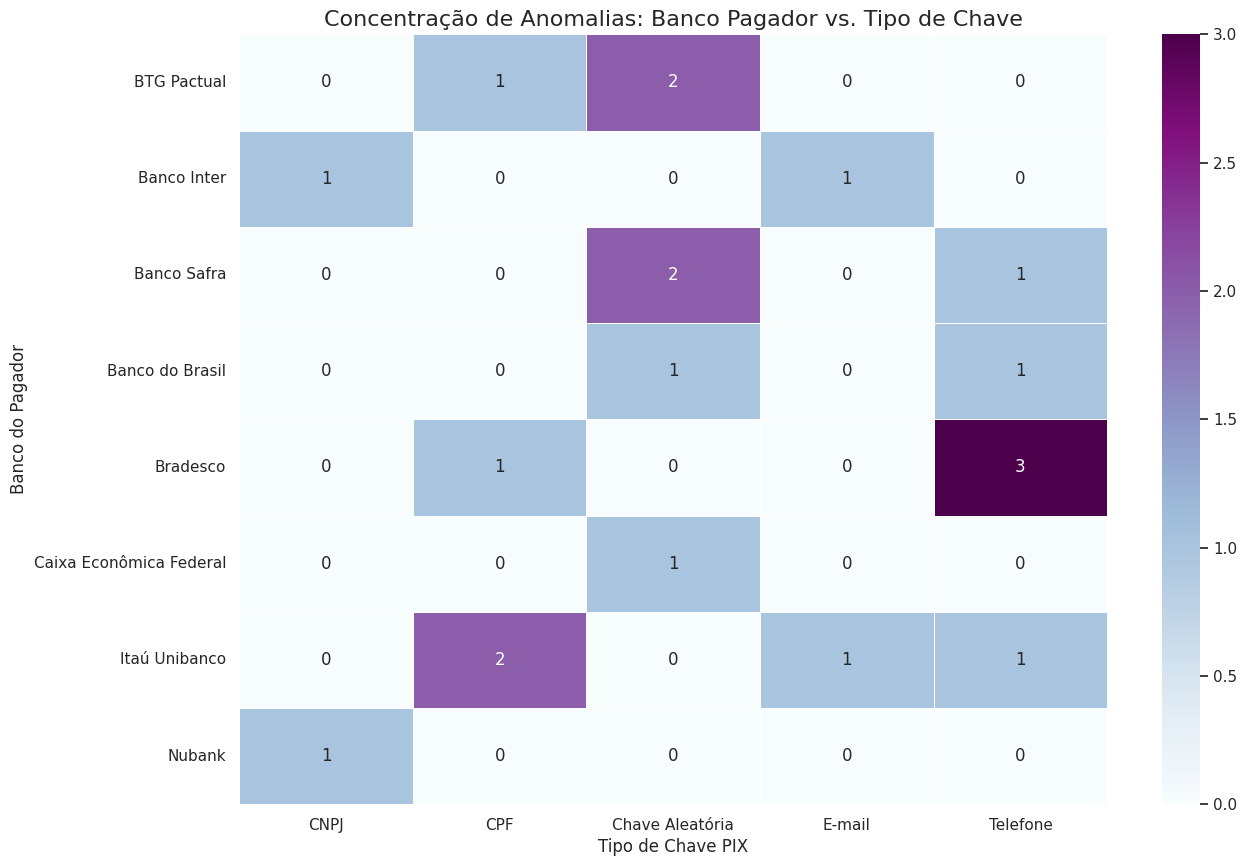

In [40]:
# --- GRÁFICO 6: Heatmap Banco Pagador vs. Tipo de Chave ---
if 'df_anomalias_sugeridas' in locals() and not df_anomalias_sugeridas.empty:
    print("\n[AÇÃO] Gerando Gráfico 6: Heatmap Banco Pagador vs. Tipo de Chave...")
    tabela_banco_chave = pd.crosstab(index=df_anomalias_sugeridas['Pagador_Banco'], columns=df_anomalias_sugeridas['TipoChave'])
    
    plt.figure(figsize=(14, 10))
    sns.heatmap(tabela_banco_chave, annot=True, fmt='d', cmap='BuPu', linewidths=.5)
    plt.title('Concentração de Anomalias: Banco Pagador vs. Tipo de Chave', fontsize=16)
    plt.xlabel('Tipo de Chave PIX', fontsize=12)
    plt.ylabel('Banco do Pagador', fontsize=12)
    plt.savefig('grafico_heatmap_banco_chave.png', bbox_inches='tight')
    print("[SUCESSO] Gráfico 'grafico_heatmap_banco_chave.png' salvo.")